In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pickle
import random

import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.ticker as tick
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed

In [2]:
# define filepath to read data
dir_path = './Challenge_Data/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test.txt'), sep='\s+', header=None, names=col_names)

train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025


In [3]:
rul_limit = 922337203
df = train
grouped_by_unit = df.groupby(by="unit_nr")
max_cycle = grouped_by_unit["time_cycles"].max()

# Merge the max cycle back into the original frame
result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

# Calculate remaining useful life for each row
remaining_useful_life = pd.Series([np.min([rul_limit, i]) for i in (result_frame["max_cycle"] - result_frame["time_cycles"]).tolist()])

In [4]:
def add_remaining_useful_life(df, rul_limit = 922337203):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = pd.Series([np.min([rul_limit, i]) for i in (result_frame["max_cycle"] - result_frame["time_cycles"]).tolist()])    
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train, 130)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,130
1,1,2,130
2,1,3,130
3,1,4,130
4,1,5,130


## Cluster-wise Standardization

In [5]:
from sklearn.preprocessing import StandardScaler
def create_clusters(df):
    model = pickle.load(open("kmeans_op.pkl", "rb"))
    preds = model.predict(df[['setting_1', 'setting_2', 'setting_3']])
    tmp = df.copy()
    tmp["op_cond"] = pd.Series(preds)
    tmp = tmp.drop(['setting_1', 'setting_2', 'setting_3'], axis=1)
    return tmp

def create_scalers(df, scaling_columns = ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6',
       's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15',
       's_16', 's_17', 's_18', 's_19', 's_20', 's_21']): #should probably just give train split here
    
    scalers = []
    for i in range(6):
        scaler = StandardScaler()
        scaler.fit(df[df["op_cond"] == i][scaling_columns])
        scalers.append(scaler)
    
    return scalers

In [6]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).reset_index(drop=True)
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

In [7]:
from sklearn.model_selection import GroupShuffleSplit
# eventhough we set np and tf seeds, gss requires its own seed
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  

def train_val_group_split(X, gss, groups, print_groups=True):
    y = X.pop('RUL')
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique(), '\n')
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split
# train = create_clusters(train)
# split_result = train_val_group_split(train, gss, train['unit_nr'])
# X_train, y_train, X_val, y_val = split_result

In [8]:
def scale(df, scalers, sensor_names = ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6',
       's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15',
       's_16', 's_17', 's_18', 's_19', 's_20', 's_21']):
    
    for condition in df['op_cond'].unique():
        scaler = scalers[condition]
        df.loc[df['op_cond']==condition, sensor_names] = scaler.transform(df.loc[df['op_cond']==condition, sensor_names])
    
    return df

In [9]:
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))
    
    if unit_nr:
        plt.plot('RUL', signal_name, 
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name, 
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

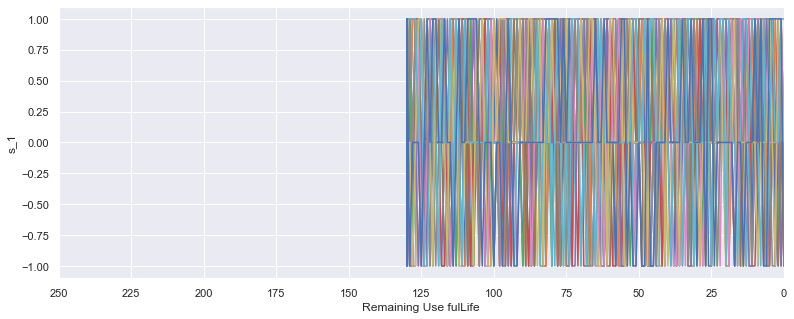

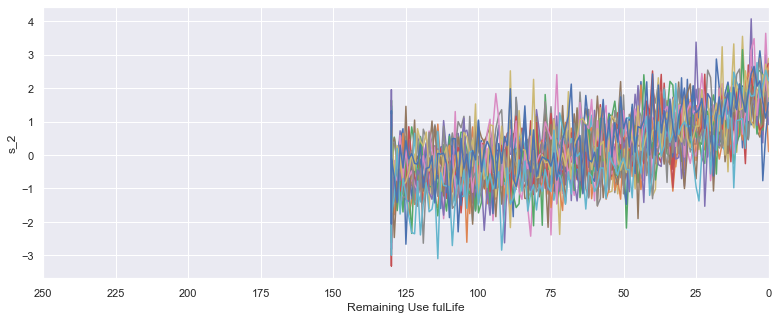

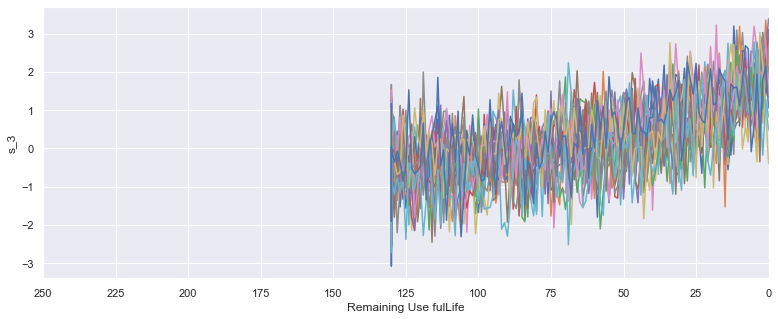

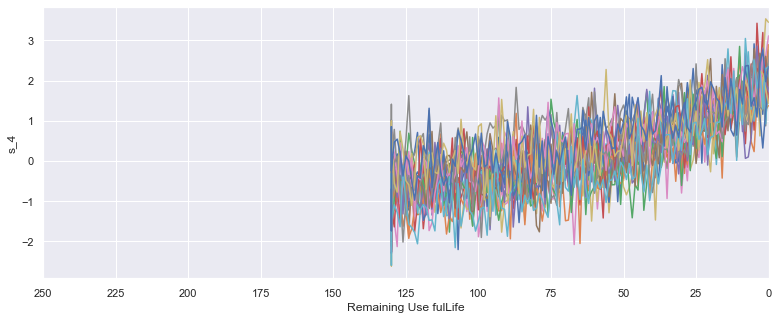

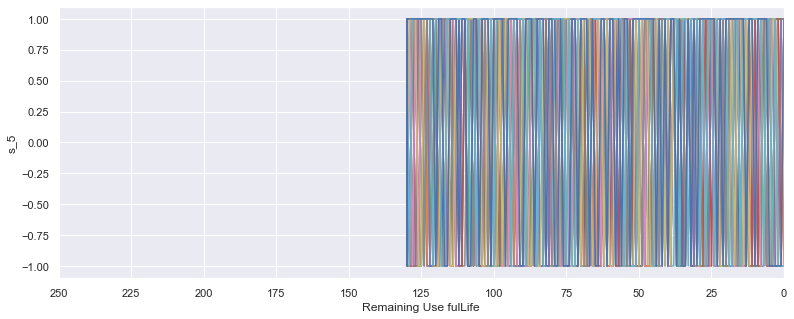

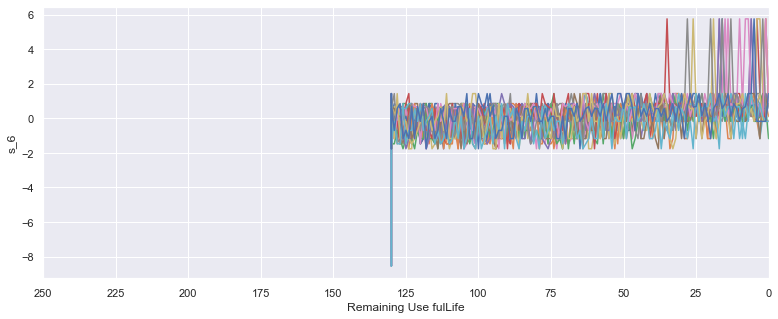

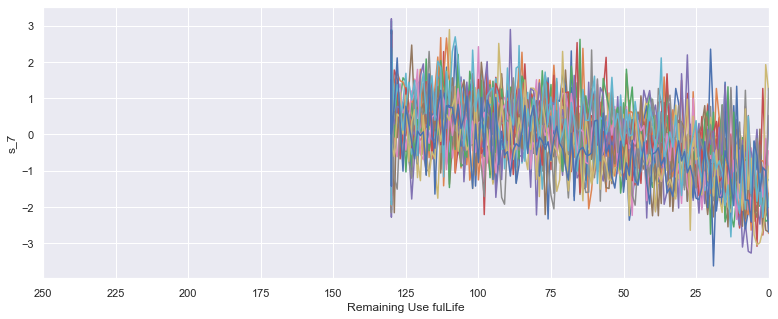

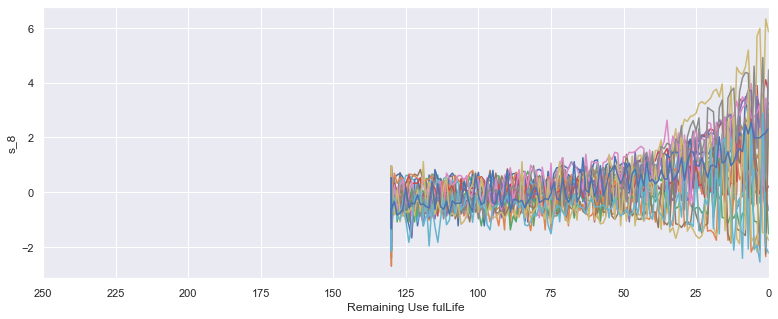

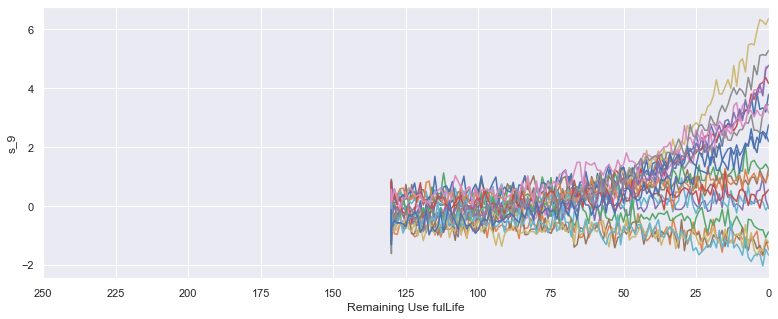

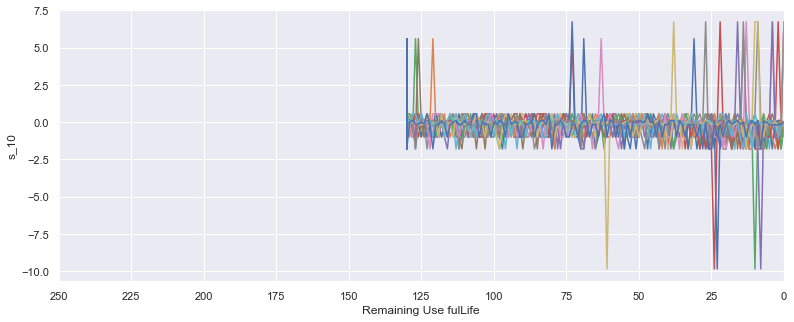

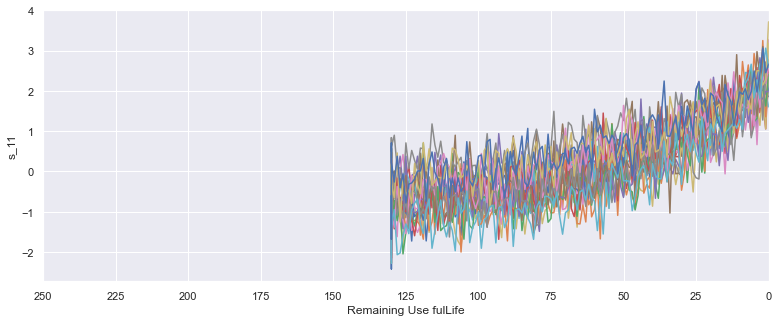

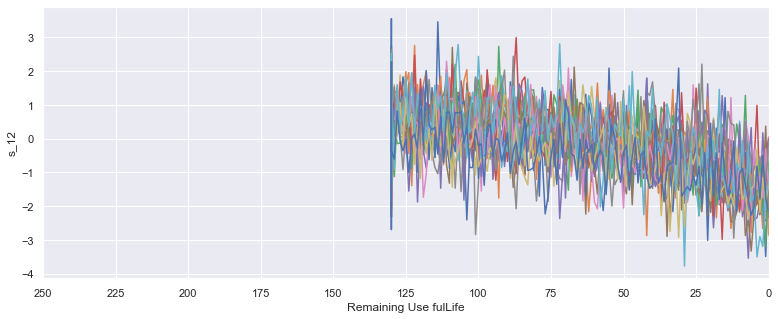

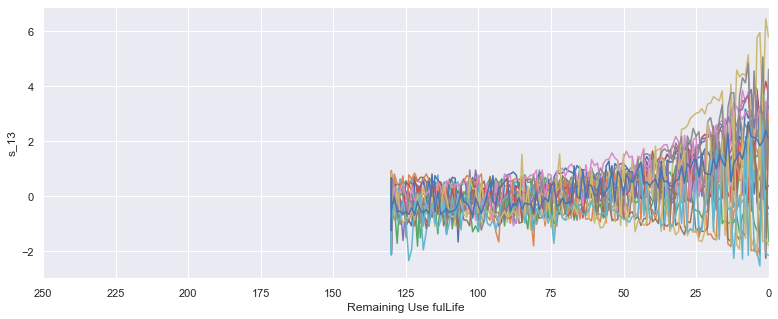

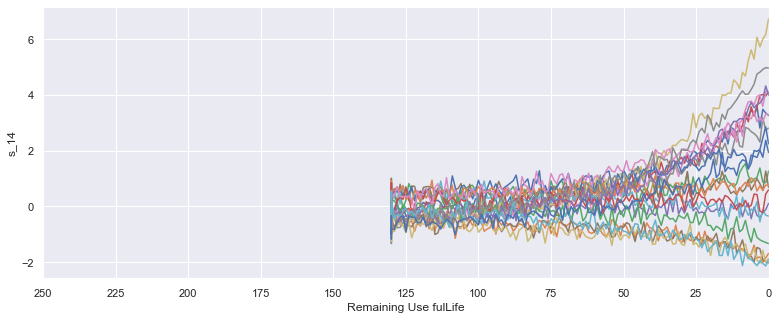

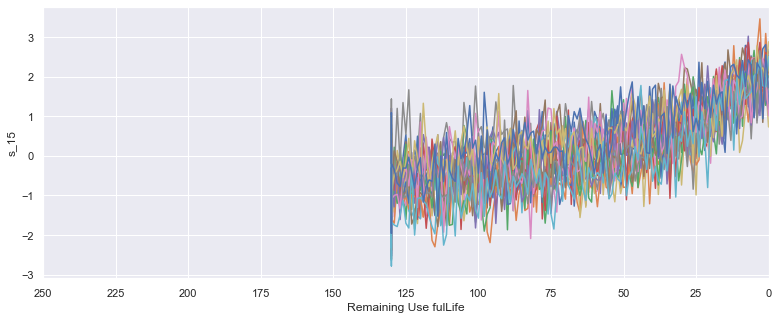

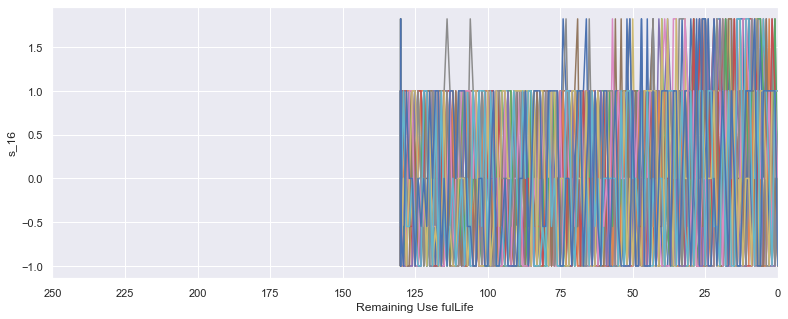

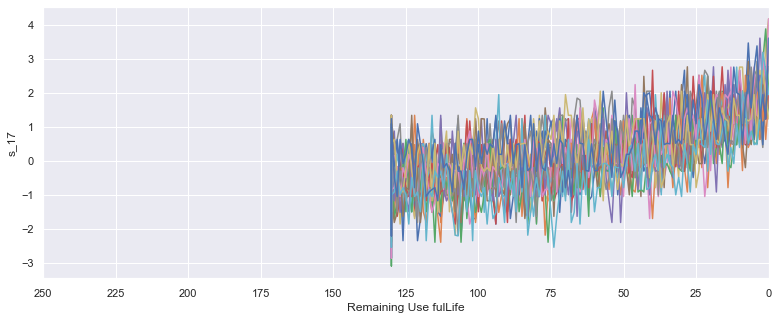

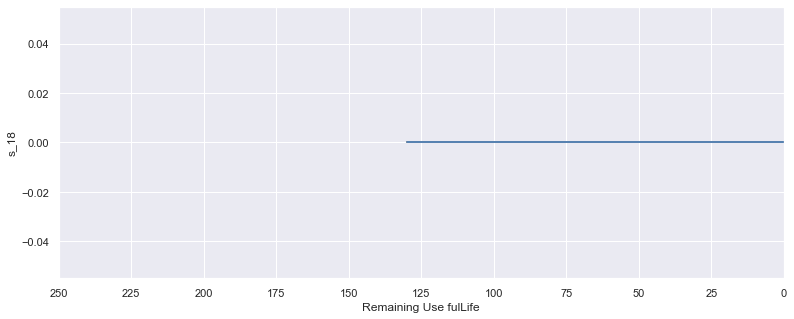

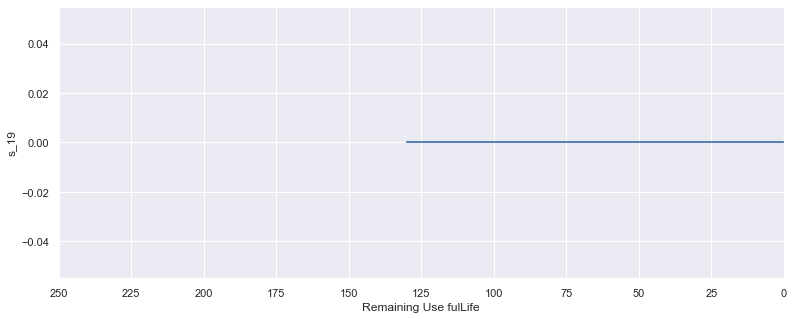

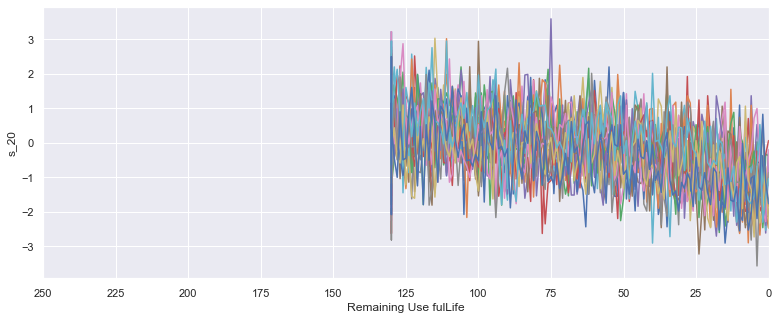

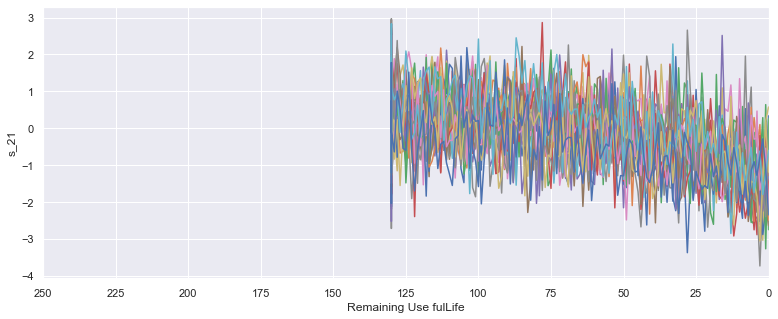

In [41]:
remaining_sensors = ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
X_train_interim = create_clusters(train)
scalers = create_scalers(X_train_interim, remaining_sensors)

X_train_condition_scaled = scale(X_train_interim, scalers, remaining_sensors)
for sensor in sensor_names:
    plot_signal(X_train_condition_scaled, sensor)

## Competition Scorer

In [42]:
import math
from sklearn.metrics import make_scorer
def phm_Score(y_true, y_pred):
    score = 0
    for t, p in zip(y_true, y_pred):
        if p >= t:
            score+= math.exp(-(p-t)/13) - 1
        else:
            score+= math.exp(-(p-t)/10) - 1
    return score/len(y_true)
my_scorer = make_scorer(phm_Score, greater_is_better=False)

## Sequencer

In [10]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [11]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [12]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]  

## LSTM

In [13]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='Test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [14]:
# remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 
#        's_11', 's_12', 's_15', 's_17', 's_20', 's_21']
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

drop_sensors = [element for element in sensor_names if element not in remaining_sensors] #s_1, s_5, s_6, s_10, s_16, s_18, s_19

In [15]:
# I know lower alpha's perform better, so we can ditch a few high ones to reduce the search space
alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)

sequence_list = list(np.arange(10,40+1,5))
epoch_list = list(np.arange(5,20+1,5))
nodes_list = [[32], [64], [128], [256], [32, 64], [64, 128], [128, 256]]

# lowest dropout=0.1, because I know zero dropout will yield better training results but worse generalization
dropouts = list(np.arange(1,5)/10)  

# again, earlier testing revealed relu performed significantly worse, so I removed it from the options
activation_functions = ['tanh', 'sigmoid']
batch_size_list = [32, 64, 128, 256]
sensor_list = [['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'],
               ['s_2', 's_3', 's_4', 's_7', 's_11', 's_12', 's_15', 's_17', 's_20', 's_21']]

tuning_options = np.prod([len(alpha_list),
                          len(sequence_list),
                          len(epoch_list),
                          len(nodes_list),
                          len(dropouts),
                          len(activation_functions),
                          len(batch_size_list),
                          len(sensor_list)])
tuning_options

100352

In [16]:
def prep_data(train, drop_sensors, remaining_sensors, alpha):
    X_train_interim = create_clusters(train.drop(drop_sensors, axis=1))

    scalers = create_scalers(X_train_interim, remaining_sensors)

    X_train_interim = scale(X_train_interim, scalers, remaining_sensors)

    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha)
    
    return X_train_interim

In [17]:
# input_shape = (sequence_length, train_array.shape[2])
def create_model(input_shape, nodes_per_layer, dropout, activation, weights_file):
    model = Sequential()
    model.add(Masking(mask_value=-99., input_shape=input_shape))
    if len(nodes_per_layer) <= 1:
        model.add(LSTM(nodes_per_layer[0], activation=activation))
        model.add(Dropout(dropout))
    else:
        model.add(LSTM(nodes_per_layer[0], activation=activation, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(nodes_per_layer[1], activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save_weights(weights_file)
    return model

In [28]:
# random grid search takes significant time, set iterations to a higher number if you truly want to tune parameters
ITERATIONS = 450

In [29]:
%%time
results = pd.DataFrame(columns=['MSE', 'std_MSE', 'alpha', # bigger std means less robust
                                'epochs', 'nodes', 'dropout', 
                                'activation', 'batch_size', 
                                'sequence_length', 'sensor_length'])  

weights_file = 'lstm_hyper_parameter_weights.h5'


for i in range(ITERATIONS):
    if ITERATIONS < 10:
        print('iteration ', i+1)
    elif ((i+1) % 10 == 0):
        print('iteration ', i+1)
    
    mse = []
    
    # init parameters
    alpha = random.sample(alpha_list, 1)[0]
    sequence_length = random.sample(sequence_list, 1)[0]
    epochs = random.sample(epoch_list, 1)[0]
    nodes_per_layer = random.sample(nodes_list, 1)[0]
    dropout = random.sample(dropouts, 1)[0]
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_size_list, 1)[0]
    remaining_sensors = random.sample(sensor_list, 1)[0]
    drop_sensors = [element for element in sensor_names if element not in remaining_sensors]
    
    # create model
    input_shape = (sequence_length, len(remaining_sensors))
    model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)
    
    # create train-val split
    X_train_interim = prep_data(train, drop_sensors, remaining_sensors, alpha)
    gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
    for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
        train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
        train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
        train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
        
        val_unit = X_train_interim['unit_nr'].unique()[val_unit]
        val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
        val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)
        
        # train and evaluate model
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration
        
        history = model.fit(train_split_array, train_split_label,
                            validation_data=(val_split_array, val_split_label),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)
        mse.append(history.history['val_loss'][-1])
    
    # append results
    d = {'MSE':np.mean(mse), 'std_MSE':np.std(mse), 'alpha':alpha, 
         'epochs':epochs, 'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'sequence_length':sequence_length,
         'sensor_length':len(remaining_sensors)}
    results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)

iteration  10
iteration  20


KeyboardInterrupt: 

In [30]:
results.sort_values('MSE')

,MSE,std_MSE,alpha,epochs,nodes,dropout,activation,batch_size,sequence_length,sensor_length
0,193.149458,20.254257,0.10,20,[256],0.2,tanh,128,40,14
9,207.576794,8.375380,0.50,5,[256],0.1,tanh,32,40,14
16,214.292229,15.911373,0.30,15,[128],0.2,sigmoid,128,40,10
4,220.971781,10.404130,0.20,15,"[128, 256]",0.1,sigmoid,32,30,10
19,226.230615,20.462223,0.10,20,"[128, 256]",0.1,tanh,128,40,14
18,226.653661,9.386759,0.20,5,[64],0.3,sigmoid,32,35,14
3,236.668899,26.409231,0.01,20,[32],0.1,sigmoid,64,40,14
5,253.305749,29.256611,0.05,20,"[128, 256]",0.3,tanh,128,25,14
15,255.828658,42.805575,0.20,10,[256],0.2,tanh,256,25,14
11,271.883194,11.684168,0.30,10,[256],0.2,tanh,256,35,10


## testing best configuration

In [32]:
def prep_data_full(train, test, drop_sensors, remaining_sensors, alpha):
    X_train_interim = create_clusters(train.drop(drop_sensors, axis=1))
    X_test_interim = create_clusters(test.drop(drop_sensors, axis=1))
    scalers = create_scalers(X_train_interim, remaining_sensors)

    X_train_interim = scale(X_train_interim, scalers, remaining_sensors)
    X_test_interim = scale(X_test_interim, scalers, remaining_sensors)
    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha)
    return X_train_interim, X_test_interim

In [54]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

drop_sensors = [element for element in sensor_names if element not in remaining_sensors] 

In [59]:
alpha = 0.4
sequence_length = 20
nodes_per_layer = [256]
dropout = 0.2
activation = 'tanh'
weights_file = 'model_weights_phm08_lstm.m5'
epochs = 15 
batch_size = 128

X_train_interim, X_test_interim = prep_data_full(train, test, drop_sensors, remaining_sensors, alpha)

# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
    train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['unit_nr'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
    
    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

# create sequences train, test 
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)


input_shape = (sequence_length, len(remaining_sensors))
model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)

model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights(weights_file)

history = model.fit(train_array, label_array,
                validation_data=(val_split_array, val_split_label),
                epochs=epochs,
                batch_size=batch_size)

Train on 37416 samples, validate on 7782 samples
Epoch 1/15
37416/37416 [==============================] - 82s 2ms/sample - loss: 3420.8631 - val_loss: 2042.8168
Epoch 2/15
37416/37416 [==============================] - 76s 2ms/sample - loss: 1051.6379 - val_loss: 483.1970
Epoch 3/15
37416/37416 [==============================] - 76s 2ms/sample - loss: 373.0266 - val_loss: 226.5272
Epoch 4/15
37416/37416 [==============================] - 76s 2ms/sample - loss: 245.7944 - val_loss: 272.1701
Epoch 5/15
37416/37416 [==============================] - 81s 2ms/sample - loss: 216.5749 - val_loss: 189.3679
Epoch 6/15
37416/37416 [==============================] - 82s 2ms/sample - loss: 197.0237 - val_loss: 152.9988
Epoch 7/15
37416/37416 [==============================] - 82s 2ms/sample - loss: 186.8889 - val_loss: 158.9802
Epoch 8/15
37416/37416 [==============================] - 80s 2ms/sample - loss: 176.7497 - val_loss: 151.6158
Epoch 9/15
37416/37416 [==============================] - 83

In [60]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_36 (Masking)         (None, 40, 14)            0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 256)               277504    
_________________________________________________________________
dropout_49 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 257       
Total params: 277,761
Trainable params: 277,761
Non-trainable params: 0
_________________________________________________________________


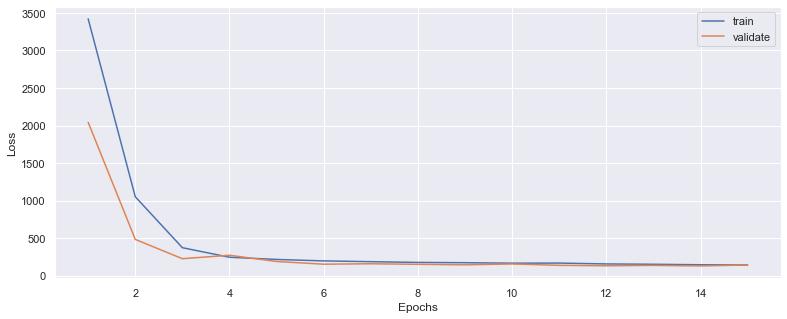

In [61]:
# plot history
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [62]:
# predict and evaluate
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(val_split_array)
evaluate(val_split_label, y_hat_test)

train set RMSE:11.65694522857666, R2:0.9274163044821877
Test set RMSE:11.958991050720215, R2:0.924199939495487


In [52]:
# predict and evaluate
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(val_split_array)
evaluate(val_split_label, y_hat_test)

train set RMSE:15.302095413208008, R2:0.8762868876736526
Test set RMSE:15.484540939331055, R2:0.8734189633973858


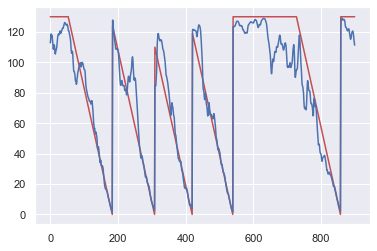

In [69]:
#previous
plt.plot(label_array[:900], c='r')
plt.plot(y_hat_train[:900], c='b')

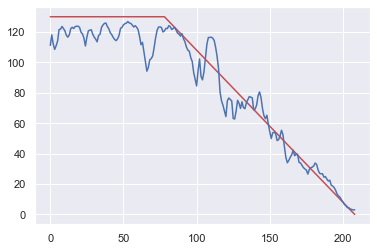

In [57]:
#new
plt.plot(val_split_label[:209], c='r')
plt.plot(y_hat_test[:209], c='b')

# Make submission

In [64]:
pred = model.predict(test_array)

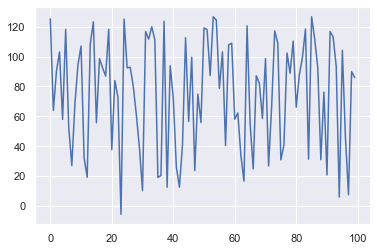

In [74]:
plt.plot(pred[:100])

In [66]:
with open("sub__05.txt", 'w') as output:
    for row in [p[0] for p in pred]:
        output.write(str(row) + '\n')